In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from nltk.corpus import state_union, stopwords
import os
from nltk.corpus import PlaintextCorpusReader
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.ensemble import RandomForestClassifier                          
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC   
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix

# 4.5.1 Unsupervised Learning Capstone
For this project you'll dig into a large amount of text and apply most of what you've covered in this unit and in the course so far.

First, pick a set of texts. This can be either a series of novels, chapters, or articles. Anything you'd like. It just has to have multiple entries of varying characteristics. At least 100 should be good. There should also be at least 10 different authors, but try to keep the texts related (either all on the same topic of from the same branch of literature - something to make classification a bit more difficult than obviously different subjects).

This capstone can be an extension of your NLP challenge if you wish to use the same corpus. If you found problems with that data set that limited your analysis, however, it may be worth using what you learned to choose a new corpus. Reserve 25% of your corpus as a test set.

The first technique is to create a series of clusters. Try several techniques and pick the one you think best represents your data. Make sure there is a narrative and reasoning around why you have chosen the given clusters. Are authors consistently grouped into the same cluster?

Next, perform some unsupervised feature generation and selection using the techniques covered in this unit and elsewhere in the course. Using those features then build models to attempt to classify your texts by author. Try different permutations of unsupervised and supervised techniques to see which combinations have the best performance.

Lastly return to your holdout group. Does your clustering on those members perform as you'd expect? Have your clusters remained stable or changed dramatically? What about your model? Is it's performance consistent?

If there is a divergence in the relative stability of your model and your clusters, delve into why.

Your end result should be a write up of how clustering and modeling compare for classifying your texts. What are the advantages of each? Why would you want to use one over the other? Approximately 3-5 pages is a good length for your write up, and remember to include visuals to help tell your story!

## Objective

The goal of this project is to train a model with texts from different authors, and determine the accuracy of the model when predicting from which author a new text belongs. 

## Text Selection and Cleaning

I selected 10 literary works from these 12 different authors:

- emerson
- shakespeare
- hawthorne
- kant
- poe
- burroughs
- doyle
- plato
- dickens
- aristotle
- jefferson
- irving 

I downloaded the .txt files from:

http://www.textfiles.com/etext/AUTHORS/

And manually cleaned the metadata from each text. Running the scripts below with their complete work required too much memory that my computer couldn't handle, so I manually cutted off from each file a part of the texts randomnly, and used this to persue my goal.

__Sections:__

[Text Processing](#section1)<br>
[Unsupervised Feature Generation](#section2)<br>
[Supervised Learning Models](#section3)<br>
[Conclusion](#section4)

<a id='section1'></a>
## Text Processing

We will create a list to store each file name and then create a loop to break each file into sentence level documents. Later, we will create a corpus root so that sentece() method can loop each text file.

In [2]:
# Make list of individual file ids
file_ids = os.listdir('../Unsupervised capstone/books/')

# Create blank labels list to populate
labels = []

# Iterate through list of files pulling out President name & year
for file in file_ids:
    
    # label author for each text 
    author = re.sub("[^a-zA-Z]", '', file[0:4])
       
    # Append to labels list
    labels.append([file, author])

In [3]:
corpus_root = '../Unsupervised capstone/books/'
newcorpus = PlaintextCorpusReader(corpus_root, '.*')

# Create blank lists to populate with sentence level data
sent_list = []
auth_list = []

# Iterate through each State of the Union, create sentence level documents, maintain President
# and year information for each sentence
for i in range(len(labels)):
    sents = newcorpus.sents(labels[i][0]) #get sentences from document
    joined_sents = [(' '.join(sent), labels[i][1]) for sent in sents]
    
    # write out to individual lists for easier text processing
    for i in range(len(joined_sents)): 
        sent_list.append(joined_sents[i][0]) 
        auth_list.append(joined_sents[i][1])  

print(len(sent_list))
sent_list[:5]

1840


['Her .',
 'I should explain to you , Socrates , that our friend Cratylus has been arguing about names ; he says that they are natural and not conventional ; not a portion of the human voice which men agree to use ; but that there is a truth or correctness in them , which is the same for Hellenes as for barbarians .',
 'Whereupon I ask him , whether his own name of Cratylus is a true name or not , and he answers " Yes ."',
 'And Socrates ?',
 '" Yes ."']

We created 1840 sentences, we will now proceed to clean them.

In [4]:
# Create list to hold cleaned up sentences
sent_list_clean = []

# Iterate through sentence list, removing punctuation, numeric values,
# frequently occuring word 'applause' that acts like a stop word in this 
# context, and sentences with all capital letters that represent title 
# information for each speech.
for sent in sent_list:
    sent = re.sub("[^a-zA-Z]", ' ', sent) #remove numeric and punctuation
    if sent == sent.upper():              #removes ALL CAPS header sentences
        sent = ""                         #replace with blank
    sent_list_clean.append(sent)

# Inspect cleaned sentences
print(len(sent_list_clean))
sent_list_clean[:4]

1840


['Her  ',
 'I should explain to you   Socrates   that our friend Cratylus has been arguing about names   he says that they are natural and not conventional   not a portion of the human voice which men agree to use   but that there is a truth or correctness in them   which is the same for Hellenes as for barbarians  ',
 'Whereupon I ask him   whether his own name of Cratylus is a true name or not   and he answers   Yes   ',
 'And Socrates  ']

Now we will tokenize the sentences into words and get the lemmas. 

In [5]:
lemmatizer = WordNetLemmatizer()

# Create list to hold lemmatized sentences
lemma_sents = []

# Tokenize, get lemmas, and rejoin back to sentence level doc
for sent in sent_list_clean:
    words = word_tokenize(sent)                                 
    word_lemma = [lemmatizer.lemmatize(word) for word in words] 
    sent_lemma = ' '.join(word_lemma)                           
    lemma_sents.append(sent_lemma)

# Inspect results
lemma_sents[:5]

['Her',
 'I should explain to you Socrates that our friend Cratylus ha been arguing about name he say that they are natural and not conventional not a portion of the human voice which men agree to use but that there is a truth or correctness in them which is the same for Hellenes a for barbarian',
 'Whereupon I ask him whether his own name of Cratylus is a true name or not and he answer Yes',
 'And Socrates',
 'Yes']

We will now create a dataframe with the cleaned lists and remove all the blank lines. We will then move on to some unsupervised feature generation.

In [6]:
# Send to data frame
df = pd.DataFrame()
df['sent'] = lemma_sents
df['author'] = auth_list

# Remove blank documents 
df = df[df.sent!=""]
df.head()

,sent,author
0,Her,plat
1,I should explain to you Socrates that our frie...,plat
2,Whereupon I ask him whether his own name of Cr...,plat
3,And Socrates,plat
4,Yes,plat


<a id='section2'></a>
## Unsupervised Feature Generation

We will now check the class balance for each author, and later generate unsupervised features with the following techniques:

* Tf-idf
* Latent Semantic Analysis

After generating the new features will split our dataset into training and test sets, fixing the latter one in 25%.

In [7]:
# Examinng class balance.
print((df.groupby('author').count()/df['sent'].count())*100)

             sent
author           
aris     9.937888
burr     6.493506
dick     5.533597
doyl     8.752117
emer     9.824958
hawt     8.187465
irvi     6.380576
jeff     7.905138
kant     4.686618
plat    12.478826
poe      4.347826
shak    15.471485


In [8]:
# Splitting data frame

df_train, df_test = train_test_split(df, stratify=df['author'], test_size=0.25, random_state=42)

# Examine shapes
print(df_train.shape)
print(df_test.shape)

(1328, 2)
(443, 2)


### Technique #1: TF-IDF Vector
The first feature generation technique we'll use is to create term frequency-inverse document frequency (TF-IDF) vectors for each word.  The following components make up the TF-IDF value:

* **Document frequency** - How many documents the word appears in.  More common words will have a higher document frequency.
* **Inverse document frequency** - Takes the log (base 2) of the ratio between the total documents to the document frequency.  More frequeny words are penalized whereas less common words become more influential.
* **Term frequency** - How many times the term appears in a document.  In our case, it's how many times a word appears in a sentence.
* **Tf-idf** - Product of the term frequency multiplied by the inverse document frequency.  Largest tf-idf scores will represent words that occur a lot in a small number of sentences, and the lowest for a word that occurs in many sentences.  The benefit of tf-idf is that you can identify unique words that may help distinguish text documents from one another.

We can calculate our TF-IDF vector matrix using TfidfVectorizer. The latter allows us to clean up more our sentences removing stop words and applying lowercase to everything.

In [9]:
vectorizer = TfidfVectorizer(stop_words='english', # Remove stop words
                             lowercase=True,       # Convert all to lowercase
                             min_df=2,             # Use words that appear at least twice per sentence
                             max_df=0.5,           # Drop words that occur in more than half of the sentences
                             use_idf=True,
                             smooth_idf=True,
                             norm='l2'
                             )

# Specify data to vectorize
X_train = df_train['sent']
X_test = df_test['sent']

# Vectorize training data
X_train_tfidf = vectorizer.fit_transform(X_train)

# Fit test data to vector
X_test_tfidf = vectorizer.transform(X_test)

# Examining shapes 
print(X_train_tfidf.shape)
print(X_test_tfidf.shape)

(1328, 2050)
(443, 2050)


We can calculate now the average TF-IDF for each word, we can see the top ten in each set, being both similar

In [10]:
# Calculate weights on training data
weights = np.asarray(X_train_tfidf.mean(axis=0)).ravel().tolist()
weights_df = pd.DataFrame({'word': vectorizer.get_feature_names(), 'avg_weight': weights})
print("Train:\n", weights_df.sort_values(by='avg_weight', ascending=False).head(10))

# Calculate weights on test data
weights = np.asarray(X_test_tfidf.mean(axis=0)).ravel().tolist()
weights_df = pd.DataFrame({'word': vectorizer.get_feature_names(), 'avg_weight': weights})
print("\nTest:\n", weights_df.sort_values(by='avg_weight', ascending=False).head(10))

Train:
       avg_weight   word
1972    0.027225     wa
1136    0.017651    man
834     0.012791     ha
1868    0.012388   time
1709    0.012048    soc
1607    0.011106    say
1029    0.010365   know
1594    0.010295   said
798     0.010012   good
1658    0.009518  shall

Test:
       avg_weight   word
1972    0.026038     wa
1136    0.016651    man
1868    0.015601   time
834     0.015148     ha
1658    0.015101  shall
1852    0.013345  think
1607    0.013117    say
798     0.013077   good
1567    0.012841  right
438     0.010505    day


### Technique #2: Latent Semantic Analysis using Singular Value Decomposition


We can use our TF-IDF vector matrix and perform Latent Semantic Analysis (LSA) on the words with the objective to gain semantic information.  LSA is performed through a dimensionality reduction technique called singluar value decompositin (SVD).  SVD is applied to a tf-idf vector matrix and the resulting components represent clusters of words that presumably reflect topics within the corpus.  

We will reduce our TF-IDF feature matrix to 30% and examine it's components.

In [11]:
# Reduce feature space to ~30% of original
svd = TruncatedSVD(600)

# Make pipeline to run svd and normalize results
lsa_pipe = make_pipeline(svd, Normalizer())

# Fit with training data, transform test data
X_train_lsa = lsa_pipe.fit_transform(X_train_tfidf)
X_test_lsa = lsa_pipe.transform(X_test_tfidf)

# Examine variance captured in reduced feature space
variance_explained = svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print('Percent variance captured by components:', total_variance*100)

sent_by_component = pd.DataFrame(X_train_lsa, index=X_train)

# Look at values from first 5 components
for i in range(6):
    print('Component {}:'.format(i))
    print(sent_by_component.loc[:, i].sort_values(ascending=False)[:5]) 

Percent variance captured by components: 83.7908834133
Component 0:
sent
Soc    1.0
Soc    1.0
Soc    1.0
Soc    1.0
Soc    1.0
Name: 0, dtype: float64
Component 1:
sent
Certainly I know him I said for he wa remarkable even then when he wa still a child and I should imagine that by this time he must be almost a young man                                                                                                                                                                                                                                                                                                                                                                                         0.452931
He wa the d or th settler of the part of the country in which I live which wa about                                                                                                                                                                                                                 

We were able to reduce the feature space to approximatelt 30% and still capture 83% of it's variation.

<a id='section3'></a>
## Supervised Learning

We will now try out our feature sets on four classification models and see how well they perform.

These are the models we will try out:

* Random Forest Classifier
* Logistic Regression
* Support Vector Classifier
* Gradient Boost Classifier

We will write out a function to test each model on both TF-IDF and LSA features and plot a confusion matrix for each case.

In [12]:
# Target variables
Y_train = df_train['author']
Y_test = df_test['author']

In [13]:
# Set up funtion to run models on both feature sets and generate accuracy scores and confusion matrices
def run_model(clf):
    
    #************ TFIDF Feature Inputs ***************
    X_train = X_train_tfidf
    X_test = X_test_tfidf
    
    # Fit with tfidf features
    clf.fit(X_train, Y_train)
    
    # Predict outcomes for confusion matrix
    Y_pred_tf = clf.fit(X_train_tfidf, Y_train).predict(X_test_tfidf)
    
    # Get results
    print('TF-IDF Features:')
    print('Train accuracy:', clf.score(X_train, Y_train))
    print('Test accuracy:', clf.score(X_test, Y_test))
    print('---------------------------------------------')

    # ************ LSA Feature Inputs *******************
    X_train = X_train_lsa
    X_test = X_test_lsa
    
    # Refit with lsa features
    clf.fit(X_train, Y_train)
    
    # Predict outcomes for confusion matrix
    Y_pred_lsa = clf.fit(X_train_lsa, Y_train).predict(X_test_lsa)
    
    print('LSA Features:')
    print('Train accuracy:', clf.score(X_train, Y_train))
    print('Test accuracy:', clf.score(X_test, Y_test))
    
    # ************ Generate Confusion Matrices ****************
    
    # Specify text labels
    labels = sorted(Y_test.unique())
    
    # Make tfidf confusion matrix, send to df
    cm_tf = confusion_matrix(Y_test, Y_pred_tf)
    df_cm_tf = pd.DataFrame(cm_tf, labels, labels)
  
    # Make lsa confusion matrix, send to df
    cm_lsa = confusion_matrix(Y_test, Y_pred_lsa)
    df_cm_lsa = pd.DataFrame(cm_lsa, labels, labels)
    
    # Setup plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))

    
    # ******************** Plot *************************
    
    # Create confusion matrix heatmaps 
    sns.heatmap(df_cm_tf, ax=ax1)
    sns.heatmap(df_cm_lsa, ax=ax2)

    # Set title and axis
    ax1.set_title('Tf-idf Confusion Matrix')
    ax2.set_title('LSA Confusion Matrix')

    ax1.set_ylabel('Actual')
    ax1.set_xlabel('Predicted')
    ax2.set_xlabel('Predicted')

    plt.tight_layout()
    plt.show()

#### Random Forest

TF-IDF Features:
Train accuracy: 0.481927710843
Test accuracy: 0.349887133183
---------------------------------------------
LSA Features:
Train accuracy: 0.538403614458
Test accuracy: 0.291196388262


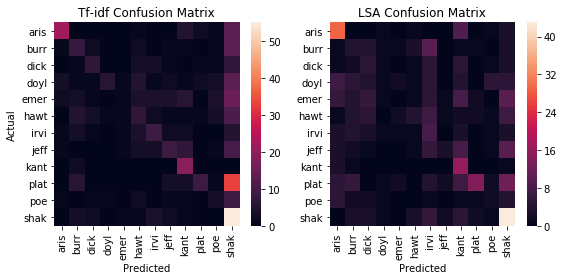

In [14]:
# Specify the classifier
clf = RandomForestClassifier(n_estimators=100,
                             max_depth=3,
                             random_state=42,
                             class_weight='balanced' 
                            )   

# Run model
run_model(clf)

Both features sets performed similarly. Looking at the confussion matrices, we can see that in both sets, we predominantely identified Aristotle's sentences.


Using the Random Forest Classifier with tf-idf features we can look at feature importances.

In [15]:
# Use model to get feature importance
feat_importance = clf.fit(X_train_tfidf, Y_train).feature_importances_
features = vectorizer.get_feature_names()

importance_df = pd.DataFrame({'word': vectorizer.get_feature_names(), 'importance': feat_importance})
importance_df.sort_values(by='importance', ascending=False).head(10)

,importance,word
1438,0.033531,principle
203,0.029603,bon
542,0.028952,duty
1025,0.024177,king
1972,0.019850,wa
75,0.019429,animal
1709,0.017815,soc
1472,0.017384,pure
1930,0.016225,union
1712,0.016048,socrates


We can see that 'principle' is the most important word.

#### Logistic Regression

TF-IDF Features:
Train accuracy: 0.870481927711
Test accuracy: 0.501128668172
---------------------------------------------
LSA Features:
Train accuracy: 0.844879518072
Test accuracy: 0.544018058691


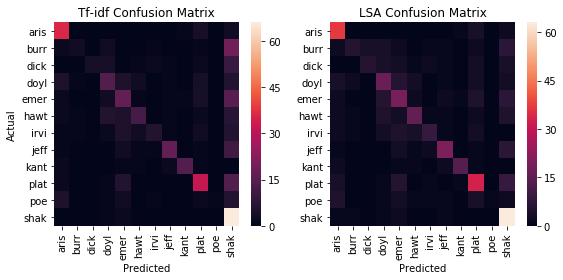

In [16]:
# Specify and run model
clf = LogisticRegression()
run_model(clf)

Logistic Regression performed much better.  Both feature sets had a similar performance predicting correctly Aristotle, Doyle, Emerson, Jefferson, Plato and Kant.

#### Support Vector Machine 

TF-IDF Features:
Train accuracy: 0.15436746988
Test accuracy: 0.155756207675
---------------------------------------------
LSA Features:
Train accuracy: 0.15436746988
Test accuracy: 0.155756207675


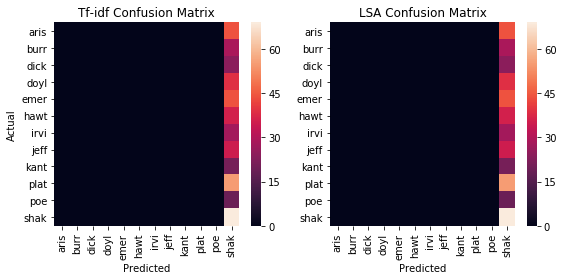

In [17]:
# Specify and run model
clf = SVC()
run_model(clf)

The Support Vector Machine Classiffier clearly didn't performed correctly.

#### Gradient Boost Classifier

TF-IDF Features:
Train accuracy: 0.96686746988
Test accuracy: 0.444695259594
---------------------------------------------
LSA Features:
Train accuracy: 0.987198795181
Test accuracy: 0.358916478555


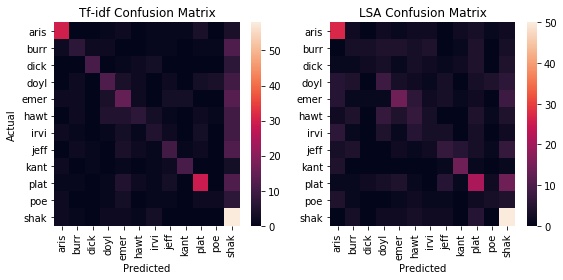

In [18]:
clf = GradientBoostingClassifier()
run_model(clf)

The Gradient Boost Classifier performed quite well, with an even better performance using the TF-IDF data set. In bothe cases, Aristotle's and Plato's were predicted with a higher accuracy.

<a id='section4'></a>
## Conclusion

Logistic Regression was the best performer mdoel, having a better than expected performance with the LSA feature set. The overall performance of the rest of the models wasn't very good, however, I think there is a lot of space for improving these models and that is starting with including the whole book from each author, looking for the best performance parameters for each model, and exploring other unsupervised techniques.